In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.activation1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.activation2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        return x

In [3]:
class LearnableActivation(nn.Module):
    def __init__(self):
        super(LearnableActivation, self).__init__()
        # 학습 가능한 스플라인 또는 작은 신경망으로 활성화 함수 구현
        self.activation = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),            
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        # x의 각 요소에 대해 활성화 함수를 적용합니다.
        # x의 크기는 임의의 차원을 가질 수 있습니다.
        return self.activation(x.unsqueeze(-1)).squeeze(-1)

class KAN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(KAN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # 가중치 매개변수를 생성합니다.
        self.weight1 = nn.Parameter(torch.randn(input_size, hidden_size))
        self.weight2 = nn.Parameter(torch.randn(hidden_size, output_size))

        # 학습 가능한 활성화 함수를 정의합니다.
        self.activation1 = LearnableActivation()
        self.activation2 = LearnableActivation()

    def forward(self, x):
        # 입력 x의 크기: (batch_size, input_size)
        
        # 첫 번째 레이어의 가중치에 활성화 함수를 적용합니다.
        activated_weight1 = self.activation1(self.weight1)
        # 입력 x와 활성화된 가중치를 사용하여 출력 계산
        x = torch.matmul(x, activated_weight1)  # 크기: (batch_size, hidden_size)
        
        # 노드에서 추가적인 비선형성을 적용하지 않습니다 (KAN의 특성).
        
        # 두 번째 레이어의 가중치에 활성화 함수를 적용합니다.
        activated_weight2 = self.activation2(self.weight2)
        # 첫 번째 레이어의 출력과 활성화된 가중치를 사용하여 최종 출력 계산
        x = torch.matmul(x, activated_weight2)  # 크기: (batch_size, output_size)
        
        # 필요에 따라 출력에 활성화 함수를 적용할 수 있습니다 (예: 회귀 문제에서는 생략).
        return x


In [4]:
# 1. B-Spline 정의
class BSpline(nn.Module):
    def __init__(self, order=3, num_knots=10):
        super(BSpline, self).__init__()
        self.order = order
        self.num_knots = num_knots
        self.knots = nn.Parameter(torch.linspace(0, 1, num_knots + order))
        self.coeffs = nn.Parameter(torch.zeros(num_knots + order - 1))
    
    def forward(self, x):
        x = (x - x.min()) / (x.max() - x.min() + 1e-8)
        basis = torch.zeros(x.size(0), self.num_knots + self.order - 1).to(x.device)
        for i in range(self.num_knots + self.order - 1):
            basis[:, i] = self.bspline_basis(x, i)
        return torch.matmul(basis, self.coeffs)
    
    def bspline_basis(self, x, i):
        return F.relu(1 - torch.abs(x - self.knots[i]))

# 2. Residual Activation Function 정의
class ResidualActivation(nn.Module):
    def __init__(self, spline_order=3, num_knots=10):
        super(ResidualActivation, self).__init__()
        self.wb = nn.Parameter(torch.ones(1))
        self.ws = nn.Parameter(torch.ones(1))
        self.basis = nn.SiLU()
        self.spline = BSpline(order=spline_order, num_knots=num_knots)
    
    def forward(self, x):
        return self.wb * self.basis(x) + self.ws * self.spline(x)

# 3. KAN Layer 정의
class KANLayer(nn.Module):
    def __init__(self, nin, nout, spline_order=3, num_knots=10):
        super(KANLayer, self).__init__()
        self.nin = nin
        self.nout = nout
        self.phi = nn.ModuleList([
            nn.ModuleList([ResidualActivation(spline_order, num_knots) for _ in range(nin)])
            for _ in range(nout)
        ])
    
    def forward(self, x):
        batch_size = x.size(0)
        out = torch.zeros(batch_size, self.nout).to(x.device)
        for j in range(self.nout):
            for i in range(self.nin):
                out[:, j] += self.phi[j][i](x[:, i])
        return out

# 4. KAN Network 정의
class KANNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, depth=2, spline_order=3, num_knots=10):
        super(KANNetwork, self).__init__()
        self.depth = depth
        self.layers = nn.ModuleList()
        self.layers.append(KANLayer(input_size, hidden_size, spline_order, num_knots))
        for _ in range(depth - 2):
            self.layers.append(KANLayer(hidden_size, hidden_size, spline_order, num_knots))
        self.layers.append(KANLayer(hidden_size, output_size, spline_order, num_knots))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [5]:
import numpy as np

# 입력 데이터 생성
x1 = np.linspace(-2*np.pi, 2*np.pi, 200)
x2 = np.linspace(-2*np.pi, 2*np.pi, 200)
X1, X2 = np.meshgrid(x1, x2)

# 입력 데이터를 벡터 형태로 변환
X_input = np.stack([X1.flatten(), X2.flatten()], axis=1)

# 실제 함수 값 계산
def f_true(x):
    return np.sin(x[:, 0] + x[:, 1])

Y_true = f_true(X_input)
Y_true.shape

(40000,)

In [6]:
# 데이터를 PyTorch 텐서로 변환
X_tensor = torch.tensor(X_input, dtype=torch.float32)
Y_tensor = torch.tensor(Y_true.reshape(-1, 1), dtype=torch.float32)

In [7]:
# 모델 초기화
input_size = 2
hidden_size = 8
output_size = 1

mlp = MLP(input_size, hidden_size*7, output_size)
kan = KANNetwork(input_size, hidden_size, output_size)

In [8]:
from torchsummary import summary

summary(mlp, input_size=(2,), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 56]             168
              ReLU-2                   [-1, 56]               0
            Linear-3                   [-1, 56]           3,192
              ReLU-4                   [-1, 56]               0
            Linear-5                    [-1, 1]              57
Total params: 3,417
Trainable params: 3,417
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [9]:
summary(kan, input_size=(2,), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
              SiLU-1                       [-1]               0
           BSpline-2                       [-1]               0
ResidualActivation-3                       [-1]               0
              SiLU-4                       [-1]               0
           BSpline-5                       [-1]               0
ResidualActivation-6                       [-1]               0
              SiLU-7                       [-1]               0
           BSpline-8                       [-1]               0
ResidualActivation-9                       [-1]               0
             SiLU-10                       [-1]               0
          BSpline-11                       [-1]               0
ResidualActivation-12                       [-1]               0
             SiLU-13                       [-1]               0
          BSpline-14                  

AttributeError: 'int' object has no attribute 'numpy'

In [10]:
# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)
kan_optimizer = torch.optim.Adam(kan.parameters(), lr=0.01)

In [11]:
# 에포크별로 결과를 저장하기 위한 리스트
epochs_to_save = [199, 399, 599, 799, 999]
mlp_outputs = []
mlp_loss_history = []
num_epochs = 1000

In [32]:
# 모델 학습
for epoch in range(num_epochs):
    mlp.train()
    
    # 순전파
    outputs_pred = mlp(X_tensor)
    loss = criterion(outputs_pred, Y_tensor)
    
    # 역전파 및 최적화
    mlp_optimizer.zero_grad()
    loss.backward()
    mlp_optimizer.step()
    
    # 손실 저장
    mlp_loss_history.append(loss.item())
    
    # 에포크별 결과 저장
    if epoch in epochs_to_save:
        with torch.no_grad():
            mlp.eval()
            Y_pred = mlp(X_tensor).detach().numpy()
            mlp_outputs.append((epoch, Y_pred))
    
    # 진행 상황 출력
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [10/1000], Loss: 0.499782
Epoch [20/1000], Loss: 0.472851
Epoch [30/1000], Loss: 0.446762
Epoch [40/1000], Loss: 0.406698
Epoch [50/1000], Loss: 0.349394
Epoch [60/1000], Loss: 0.292118
Epoch [70/1000], Loss: 0.247845
Epoch [80/1000], Loss: 0.222887
Epoch [90/1000], Loss: 0.203383
Epoch [100/1000], Loss: 0.184454
Epoch [110/1000], Loss: 0.166230
Epoch [120/1000], Loss: 0.149112
Epoch [130/1000], Loss: 0.134636
Epoch [140/1000], Loss: 0.123316
Epoch [150/1000], Loss: 0.126995
Epoch [160/1000], Loss: 0.096000
Epoch [170/1000], Loss: 0.082408
Epoch [180/1000], Loss: 0.070865
Epoch [190/1000], Loss: 0.058877
Epoch [200/1000], Loss: 0.054551
Epoch [210/1000], Loss: 0.036381
Epoch [220/1000], Loss: 0.029040
Epoch [230/1000], Loss: 0.036745
Epoch [240/1000], Loss: 0.024118
Epoch [250/1000], Loss: 0.015055
Epoch [260/1000], Loss: 0.013603
Epoch [270/1000], Loss: 0.027066
Epoch [280/1000], Loss: 0.017102
Epoch [290/1000], Loss: 0.014435
Epoch [300/1000], Loss: 0.012169
Epoch [310/1000], L

In [14]:
# 에포크별 결과 시각화 함수 정의
def plot_approximations_torch(X1, X2, Y_true, outputs):
    fig = plt.figure(figsize=(18, 12))

    # 실제 함수 시각화
    ax = fig.add_subplot(1, 6, 1, projection='3d')
    ax.plot_surface(X1, X2, Y_true.reshape(X1.shape), cmap='viridis')
    ax.set_title('Actual Function')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('f(x1, x2)')

    # 에포크별 근사 결과 시각화
    for i, (epoch, Y_pred) in enumerate(outputs):
        ax = fig.add_subplot(1, 6, i+2, projection='3d')
        ax.plot_surface(X1, X2, Y_pred.reshape(X1.shape), cmap='viridis')
        ax.set_title(f'Approximation at Epoch {epoch+1}')
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('Approximation')

    plt.tight_layout()
    plt.show()

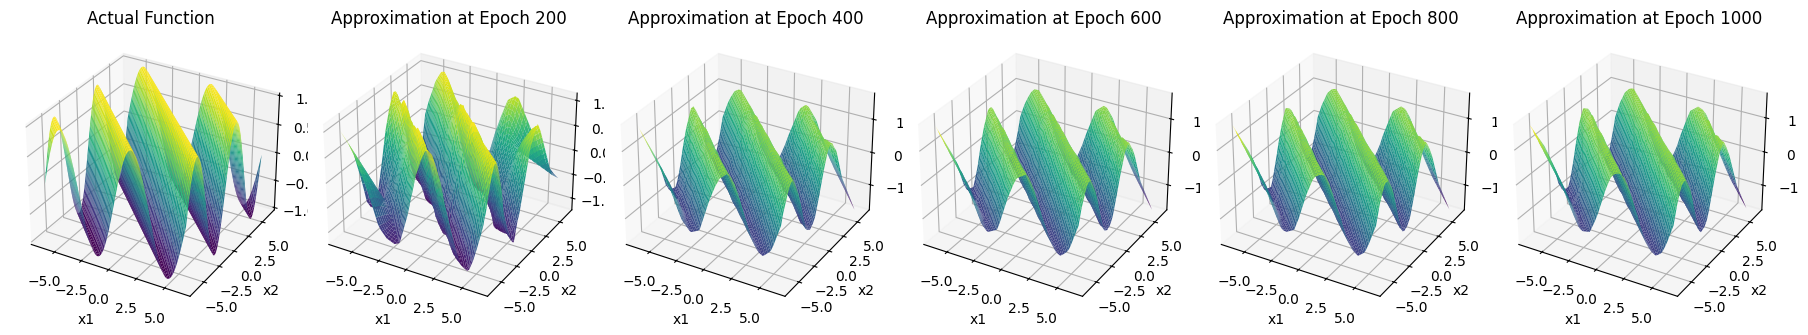

In [ ]:
plot_approximations_torch(X1, X2, Y_true, mlp_outputs)

In [12]:
kan_outputs = []
kan_loss_history = []

In [13]:
# 모델 학습
for epoch in range(num_epochs):
    kan.train()
    
    # 순전파
    outputs_pred = kan(X_tensor)
    loss = criterion(outputs_pred, Y_tensor)
    
    # 역전파 및 최적화
    kan_optimizer.zero_grad()
    loss.backward()
    kan_optimizer.step()
    
    # 손실 저장
    kan_loss_history.append(loss.item())
    
    # 에포크별 결과 저장
    if epoch in epochs_to_save:
        with torch.no_grad():
            kan.eval()
            Y_pred = kan(X_tensor).detach().numpy()
            kan_outputs.append((epoch, Y_pred))
    
    # 진행 상황 출력
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [10/1000], Loss: 280.290710
Epoch [20/1000], Loss: 109.876015
Epoch [30/1000], Loss: 59.365143
Epoch [40/1000], Loss: 24.681419
Epoch [50/1000], Loss: 13.521521
Epoch [60/1000], Loss: 8.169136
Epoch [70/1000], Loss: 5.159382
Epoch [80/1000], Loss: 3.688449
Epoch [90/1000], Loss: 2.948040
Epoch [100/1000], Loss: 2.498942
Epoch [110/1000], Loss: 2.176599
Epoch [120/1000], Loss: 1.927636
Epoch [130/1000], Loss: 1.734624
Epoch [140/1000], Loss: 1.586330
Epoch [150/1000], Loss: 1.470481
Epoch [160/1000], Loss: 1.377169
Epoch [170/1000], Loss: 1.299928
Epoch [180/1000], Loss: 1.234745
Epoch [190/1000], Loss: 1.178738
Epoch [200/1000], Loss: 1.129921
Epoch [210/1000], Loss: 1.086900
Epoch [220/1000], Loss: 1.048525
Epoch [230/1000], Loss: 1.014084
Epoch [240/1000], Loss: 0.982857
Epoch [250/1000], Loss: 0.954396
Epoch [260/1000], Loss: 0.928328
Epoch [270/1000], Loss: 0.904174
Epoch [280/1000], Loss: 0.881773
Epoch [290/1000], Loss: 0.860941
Epoch [300/1000], Loss: 0.841419
Epoch [310/1

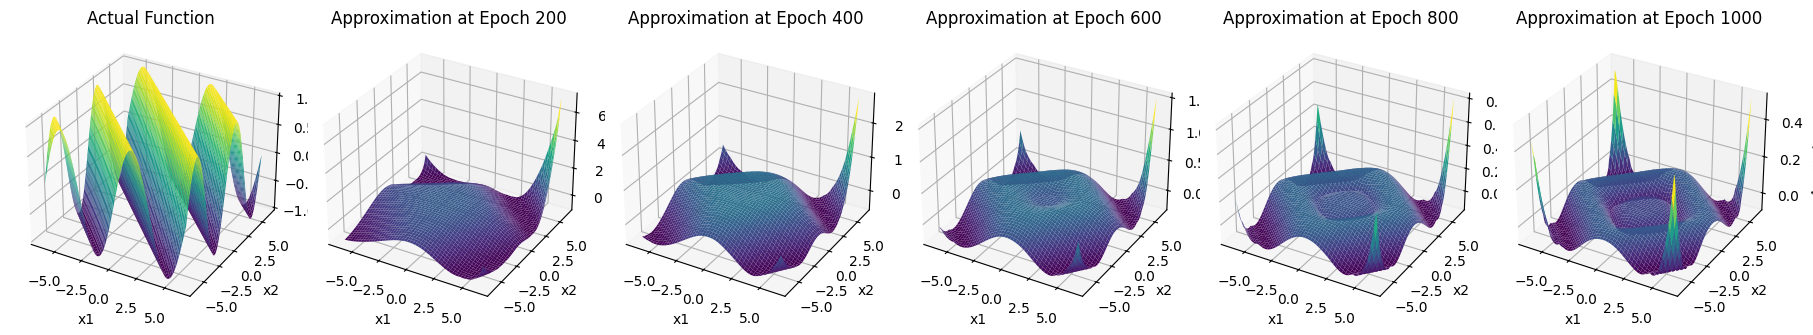

In [15]:
plot_approximations_torch(X1, X2, Y_true, kan_outputs)